In [38]:
# Get system path 
import os
path = os.getcwd()
# Get parent directory
parent = os.path.dirname(path)
#Add parent directory to system path
os.sys.path.insert(0, parent)

import numpy as np
import matplotlib.pyplot as plt

from lib.utils import *
from lib.plot_utils import *   
from lib.event_processing import *
from lib.real_time_video import *

from metavision_core.event_io import EventsIterator
from metavision_sdk_core import PeriodicFrameGenerationAlgorithm
from metavision_sdk_ui import EventLoop, BaseWindow, Window, UIAction, UIKeyEvent

# Get the runtimes of the different methods
import time

import numba as nb
from numba import jit, njit

#Dynamicaly reload modules in juptyer notebook
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
path = "../data/recordings/02_02/recording_2024-02-02_17-21-24_FOV14.3_MAG6.raw"
# path = "../data/recordings/02_02/recording_2024-02-02_17-26-59_FOV11.8_MAG6.raw"

mv_iterator = EventsIterator(input_path=path, delta_t=10000)

height, width = mv_iterator.get_size()  # Camera Geometry
event_frame_gen = PeriodicFrameGenerationAlgorithm(width, height, accumulation_time_us=100000)

frames = np.zeros((height, width,1), dtype=np.uint8)

print(frames.shape)

def on_cd_frame_cb(ts, cd_frame):
    global frames  # Add this line to access the global frames variable
    gray_frame = np.reshape(cv2.cvtColor(cd_frame, cv2.COLOR_BGR2GRAY), (height, width, 1))
    frames = np.append(frames,gray_frame, axis=-1)  # Append the gray_frame as a new row to the frames array
    
event_frame_gen.set_output_callback(on_cd_frame_cb)

for evs in mv_iterator:
    event_frame_gen.process_events(evs)

print(frames.shape)


(720, 1280, 1)
(720, 1280, 115)


In [54]:
innit_fame = np.zeros((height, width,1), dtype=np.uint8)

pixel_to_deg = {'ref_pixel_to_deg': 0.0009500350877192982,
        'reference_FOV': 1,
        'recording_FOV': 13.7}

cluster_frame = ClusterFrame(
    innit_fame,
    pixel_to_deg =pixel_to_deg,
    pixel_range=15, 
    treshold_filter= 0.2, 
    mass_treshold= 0.2, 
    max_number_of_clusters=30)

cluster_frame.load_som_parameters('acc96_n89_89_tycho6_permutation_multi_permutation')
cluster_frame.load_star_catalog('../data/catalogs/tycho2_VT_6.csv')
cluster_video = ClusterVideo()

SOM Parameters loaded correctly
(4566, 3)  Stars loaded


In [47]:
path = "../data/recordings/02_02/recording_2024-02-02_17-21-24_FOV14.3_MAG6.raw"
# path = "../data/recordings/02_02/recording_2024-02-02_17-26-59_FOV11.8_MAG6.raw"

mv_iterator = EventsIterator(input_path=path, delta_t=10000)

height, width = mv_iterator.get_size()  # Camera Geometry
event_frame_gen = PeriodicFrameGenerationAlgorithm(width, height, accumulation_time_us=100000)

frames = np.empty((0, height, width), dtype=np.uint8) 

def on_cd_frame_cb(ts, cd_frame):
    global frames  # Add this line to access the global frames variable
    gray_frame = np.reshape(cv2.cvtColor(cd_frame, cv2.COLOR_BGR2GRAY), (1, height, width))
    frames = np.append(frames,gray_frame, axis=0)  # Append the gray_frame as a new row to the frames array
    
event_frame_gen.set_output_callback(on_cd_frame_cb)

frames_buffer = [] # Only list allowed

for evs in mv_iterator:

    event_frame_gen.process_events(evs)

    if frames.shape[0] == 10:
        compact_frames = blend_buffer(frames, True)
        frames_buffer.append(frames)
        frames = np.empty((0, height, width), dtype=np.uint8) 
        
print (len(frames_buffer), frames_buffer[0].shape)
# cluster_frame.print_total_time()

11 (10, 720, 1280)


--- 0.014665885405106978 seconds ---
--- 0.0035132494839754972 seconds ---
Buffer:  (10, 720, 1280)
(720, 1280)


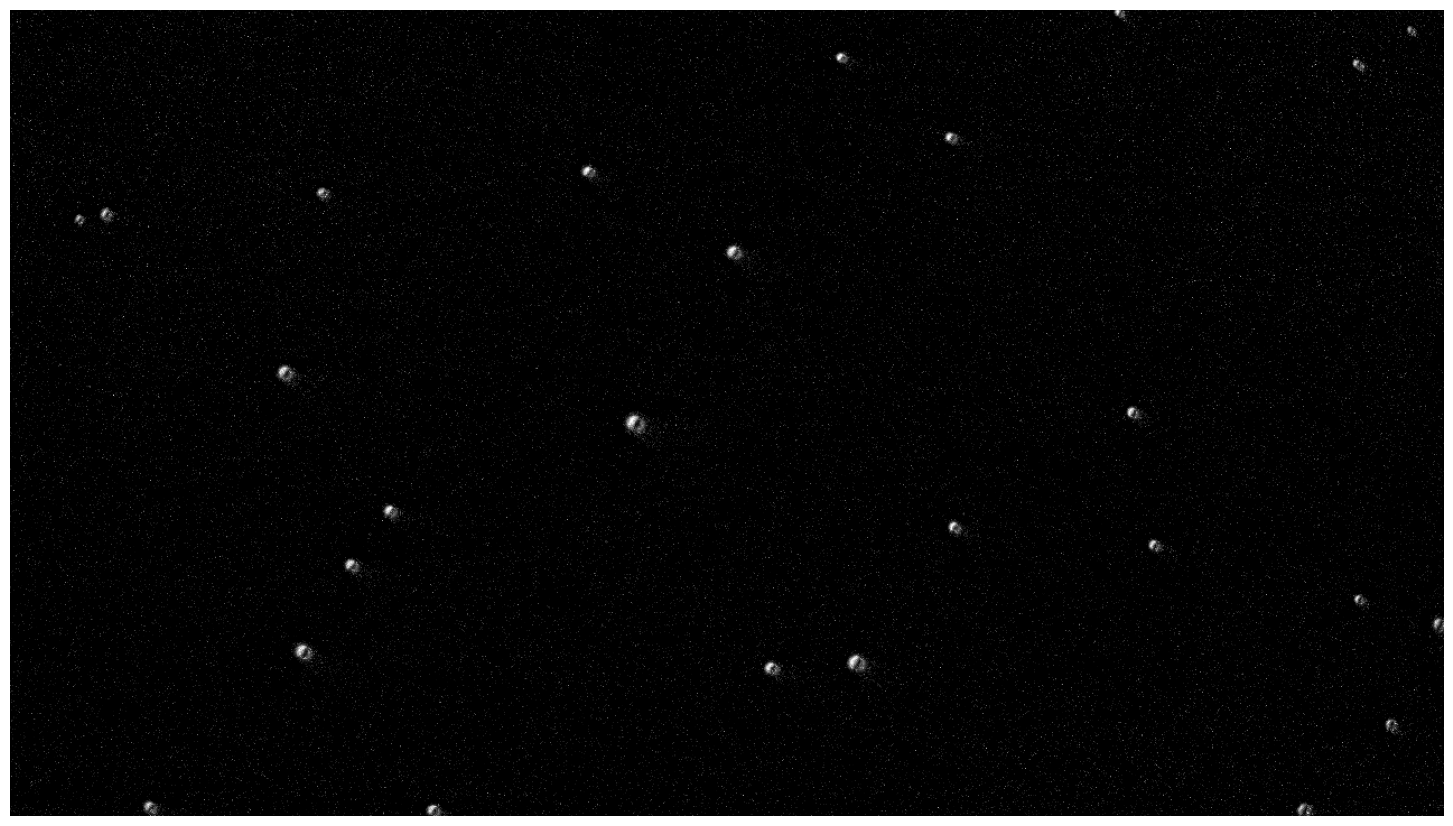

In [6]:
def blend_buffer(frames_buffer, mirror = False):
    ''' Get a frame buffer and compacts it into a single frame  
    '''

    # Stack all grayscale frames along a new axis
    stacked_frames = np.stack(frames_buffer, axis=0)
    # stacked_frames = np.concatenate(frames_buffer, axis=-1)

    # Average the values along the last axis
    blend = np.mean(stacked_frames, axis=0)

    # Mirror the image
    if mirror:
        blend = np.fliplr(blend)

    return blend.astype(np.uint8) 

@njit(fastmath=True, parallel=True)
def blend_buffer_2(frames_buffer, mirror = False):
    ''' Get a frame buffer and compacts it into a single frame '''
    stacked_frames = np.zeros(frames_buffer[0].shape, dtype=np.uint16) 

    for i in range(frames_buffer.shape[0]):
        stacked_frames += frames_buffer[i]
    blend = stacked_frames / frames_buffer.shape[0] # Average the frames

    if mirror:
        blend = np.fliplr(blend)
    
    return blend.astype(np.uint8)  # Convert back to uint8 before returning

start_time = time.time()
for buffer in frames_buffer:
    compact_frames = blend_buffer( buffer, True)
print("--- %s seconds ---" % ((time.time() - start_time)/len(frames_buffer)))

blend_buffer_2(frames_buffer[0], True)
start_time = time.time()
for buffer in frames_buffer:
    compact_frames = blend_buffer_2(buffer, True)
print("--- %s seconds ---" % ((time.time() - start_time)/len(frames_buffer)))

print('Buffer: ', frames_buffer[0].shape)
print(compact_frames.shape)
plot_image(np.squeeze(compact_frames))

In [7]:

frame = compact_frames
start_time = time.time()
for i in range(1000):
    max_index = np.unravel_index(np.argmax(frame), frame.shape)
print("--- %s seconds ---" % (time.time() - start_time))


get_max_index(frame)
start_time = time.time()
for i in range(1000):
    max_index = get_max_index(frame)
print("--- %s seconds ---" % ((time.time() - start_time)))




get_argmax(compact_frames)
start_time = time.time()
for i in range(1000):
    max_index = np.unravel_index(get_argmax(frame), frame.shape)
print("--- %s seconds ---" % (((time.time() - start_time))) )



--- 1.007331132888794 seconds ---
--- 0.6573569774627686 seconds ---
--- 0.765465497970581 seconds ---


Time normalize + blur:  0.0012156709999544546
Time threshold:  0.00021354500131565146
Time cluster:  0.02261918500153115
Time sort:  6.286700227065012e-05
Time index:  0.00019359399811946787
Time treshold:  0.00022184000044944696


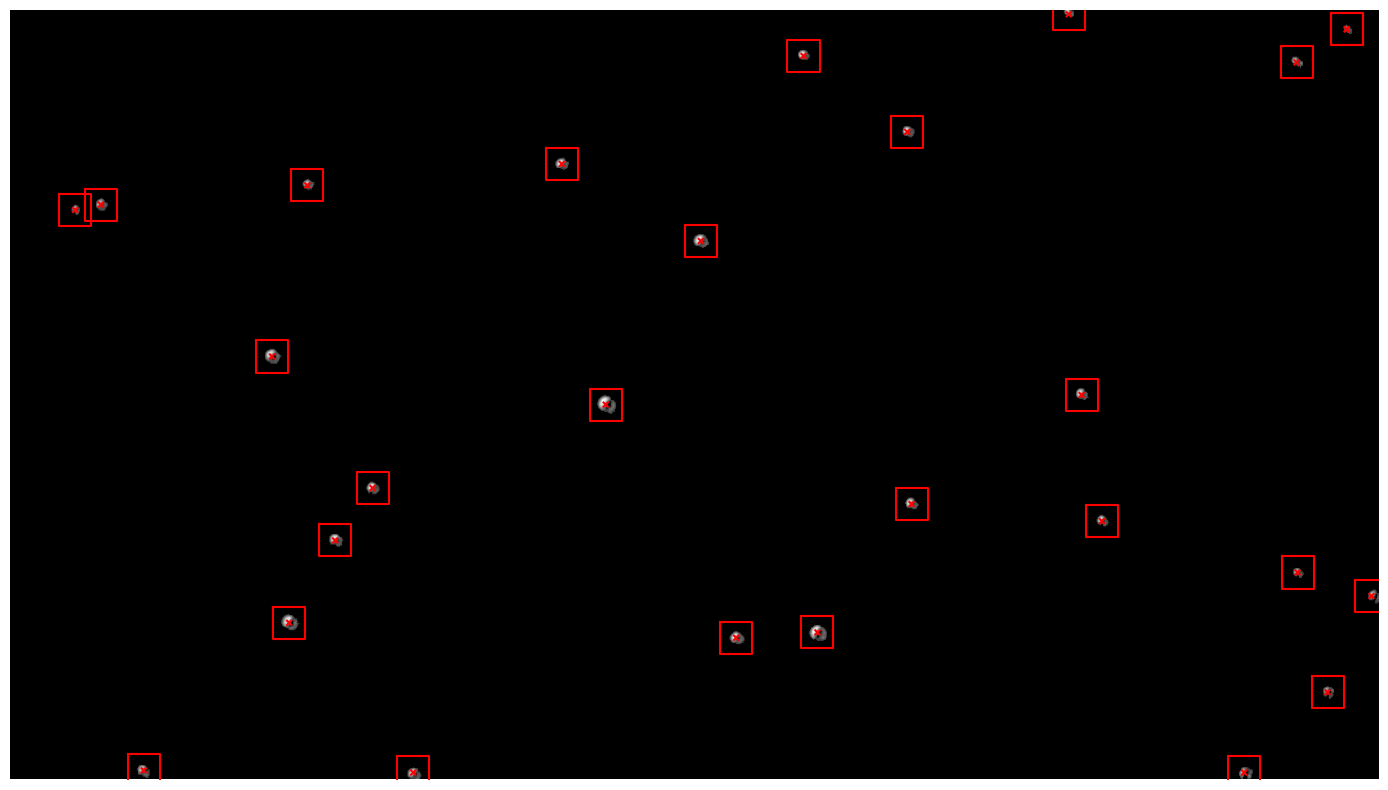

In [8]:
@njit(fastmath=True)
def max_value_cluster_2(frame, pixel_range, n_clusters):

    img = np.copy(frame)
    clusters = np.empty((1,3), dtype=np.int32)

    height, width = img.shape
    
    for _ in range(n_clusters):

        # max_index = np.unravel_index(get_argmax(img), img.shape)
        max_index = get_max_index(img)

        start_row = max_index[0] - pixel_range
        end_row = max_index[0] + pixel_range + 1
        start_col = max_index[1] - pixel_range
        end_col = max_index[1] + pixel_range + 1

        if start_row < 0:
            start_row = 0
        if end_row > height:
            end_row = height
        if start_col < 0:
            start_col = 0
        if end_col > width:
            end_col = width


        cluster_x, cluster_y, cluster_mass = get_cluster_cg(start_row, end_row, start_col, end_col, img)

        if cluster_mass != 0:
            centroid_x = np.int32(cluster_x / cluster_mass)
            centroid_y = np.int32(cluster_y / cluster_mass)
            cluster = np.reshape( np.array( (centroid_x, centroid_y, cluster_mass), dtype=np.int32), (1,3))
            clusters = np.append(clusters, cluster, axis=0)
        
        delete_pixels(img, start_row, end_row, start_col, end_col)    

    return clusters

pixel_range = 15
mass_treshold = 0.2
n_clusters = 30

start_time = time.perf_counter()
frame = cv2.blur(compact_frames,(3,3))
frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)
time_norm = time.perf_counter() -start_time
print('Time normalize + blur: ', time_norm)


treshold = 0.2
frame_threshold(frame, treshold)
start_time = time.perf_counter()
frame_thr = frame_threshold(frame, treshold)
time_thr = time.perf_counter() -start_time 
print('Time threshold: ', time_thr)

max_value_cluster_2(frame_thr, pixel_range, n_clusters)
start_time = time.perf_counter()
clusters =  max_value_cluster_2(frame_thr, pixel_range, n_clusters)
time_cluster = time.perf_counter() -start_time 
print('Time cluster: ', time_cluster)

sort_by_mass(clusters)
start_time = time.perf_counter()
clusters = sort_by_mass(clusters)
time_sort = time.perf_counter() -start_time 
print('Time sort: ', time_sort)



index_cluster_2(frame, pixel_range, clusters[:,0:2])
if True:
    start_time = time.perf_counter()
    clusters_list_full = index_cluster_2(frame, pixel_range, clusters[:,0:2])
    time_index = time.perf_counter() -start_time 
    print('Time index: ', time_index)

start_time = time.perf_counter()
if mass_treshold is not None:
    treshold_val = mass_treshold*np.max(clusters_list_full[:,2])
    clusters_list_full = clusters_list_full[clusters_list_full[:,2] > treshold_val]
print('Time treshold: ', time.perf_counter() -start_time)

# start_time = time.perf_counter()
# clusters_list_full, _= order_by_center_dist(clusters_list_full, frame.shape)
# clusters_list = [x[0] for x in clusters_list_full]
# time_order = time.perf_counter() -start_time 
# print('Time order: ', time_order)
    
# print(clusters_list_full)

print_list = []
for cluster in clusters_list_full:
    print_list.append(cluster[0:2])
 
plot_cluster(frame_thr, print_list, pixel_range, [18.5,10])

Time normalize + blur:  0.001207196997711435
Time threshold:  0.00042732200017780997
Time cluster:  0.018810834997566417
Time sort:  6.014900282025337e-05
Time index:  0.005768507002358092
Time order:  0.0002926029992522672

In [9]:

cluster_frame.frame = compact_frames
cluster_frame.compute_clusters_2()

start_time = time.perf_counter()
for i in range(100):
    cluster_frame.compute_clusters_2()
print('Time cluster: ', (time.perf_counter() -start_time)/100)

Time cluster:  0.02776963838001393


In [10]:
cluster_frame.clusters_list_full.shape

(26, 3)

In [11]:
import numba


def test(ej):
    return np.linalg.norm(ej, ord=None)
    # return np.argsort(ej)

@njit(fastmath=True, parallel=True)
def lg_norm(a):
    norms = np.empty(a.shape[1], dtype=a.dtype)
    for i in numba.prange(a.shape[1]):
        norms[i] = np.sqrt(a[0, i] * a[0, i] + a[1, i] * a[1, i])
    return norms

start_time = time.perf_counter()
for i in range(10000):
    a = test(cluster_frame.clusters_list.T)
print('Time cluster: ', (time.perf_counter() -start_time)/10000)

lg_norm(cluster_frame.clusters_list.T)
start_time = time.perf_counter()
for i in range(10000):
    a = lg_norm(cluster_frame.clusters_list.T)
print('Time cluster: ', (time.perf_counter() -start_time)/10000)

print(a)

Time cluster:  9.33416559964826e-06
Time cluster:  1.0790142599944375e-05
[ 668  953  629  681  406  897  581  561  535  806  961 1064  846  721
  743 1356  200 1127  322 1385 1387 1203  990 1313  196 1250]


In [12]:
def order_by_main_dist_2(main_cluster, clusters, get_index = False):
    if clusters.shape[0] > 2:

        rest = clusters - main_cluster
        distances = np.linalg.norm(rest, axis=1)
        # Sort clusters based on distances
        sorted_indices = np.argsort(distances)
        sorted_clusters = clusters[sorted_indices]

        if get_index:
            return sorted_clusters, sorted_indices
        else:
            return sorted_clusters

order_by_main_dist_2(cluster_frame.clusters_list[0], cluster_frame.clusters_list, True)
start_time = time.perf_counter()
for cluster in cluster_frame.clusters_list:
    stars_sorted_by_main, index_sort = order_by_main_dist_2(cluster, cluster_frame.clusters_list, True)
print('Time order: ', (time.perf_counter() -start_time))

print(index_sort[0:5])


Time order:  0.0006400540005415678
[25 21 22 12 11]


In [13]:

@njit(fastmath=True, parallel=True)
def lg_norm(a):
    norms = np.empty(a.shape[1], dtype=a.dtype)
    for i in numba.prange(a.shape[1]):
        norms[i] = np.sqrt(a[0, i] * a[0, i] + a[1, i] * a[1, i])
    return norms

@njit(fastmath=True)
def log_polar_transform_2(main_point, secondary_point, axis_ref):
    r = np.log( lg_norm( np.reshape(main_point - secondary_point, (2,1)))[0] ) 
    theta = ( np.arctan2(secondary_point[1],secondary_point[0]) - np.arctan2(axis_ref[1],axis_ref[0]) + 2 * np.pi) % (2 * np.pi)
    return np.float32(r), np.float32(theta) 

star_list = stars_sorted_by_main[0:4+1]
log_polar_transform_2(star_list[0],star_list[2], star_list[1])
start_time = time.perf_counter()
for i in range(10000):
    log_polar_transform(star_list[0],star_list[2], star_list[1])
print('Time log polar: ', (time.perf_counter() -start_time))


Time log polar:  0.14952957999776118


In [14]:
@njit
def get_star_features_fast(star_list, ref_pixel_to_deg = 1, reference_FOV = 1, recording_FOV = 1):

    star_features_1 = np.empty((1,),  dtype=np.float64)
    star_features_2 = np.empty((1,),  dtype=np.float64)
    pixel_to_deg = ref_pixel_to_deg * recording_FOV/reference_FOV
    star_list = star_list * pixel_to_deg

#  Center the star list in the mean position (avoid traslation problems)
    # star_list = star_list - np.mean(star_list, axis=0) #TODO: CHECK
    star_list = star_list - star_list[0]

    for j in range(star_list.shape[0]):
        if j != 0:
            # Log polar transform
            star_features_1 = np.append(star_features_1,log_polar_transform_2(star_list[0],star_list[j], star_list[1]))
        # Compute distance between each neirbour star (permutation)
        for k in range(j+1,len(star_list)):
            dist =  lg_norm(np.reshape(star_list[k] - star_list[j], (2,1)) ) 
            star_features_2 = np.append(star_features_2, dist)

    # Delete first element
    star_features_1 = np.delete(star_features_1, 0)
    star_features_2 = np.delete(star_features_2, 0)

    return star_features_1, star_features_2

get_star_features_fast(stars_sorted_by_main[0:4+1])
start_time = time.perf_counter() #delete
for i in range(cluster_frame.clusters_list.shape[0]):
    stars_features_1, stars_features_2 = get_star_features_fast(stars_sorted_by_main[0:4+1])
print('Time get_star_features: ', (time.perf_counter() -start_time))

Time get_star_features:  0.0015986129983502906


In [15]:
def predict_star_id(features, norm_param, dictionary, som):

    normalized_feature = (features - norm_param[0]) / (norm_param[1] - norm_param[0])

    winner = som.winner(normalized_feature)
    if winner in dictionary:
        return dictionary[winner]
    else:
        return [0] #The neuron has no star ID return [0], the ID starts at 1 


In [16]:
from numpy import subtract
import numba as nb


@njit(fastmath=True, parallel=True)
def euclidean_norm(a):
    norms = np.empty(a.shape[0:2], dtype=a.dtype)
    for i in numba.prange(a.shape[0]):
        for j in numba.prange(a.shape[1]):
            norms[i,j] = np.sqrt(np.dot(a[i,j], a[i,j]))
    return norms

@njit(fastmath=True, parallel=True)
def compute_winner(features, weights): 
    activation_map = euclidean_norm(np.subtract(features, weights))
    return activation_map.argmin()


# ravel_winner = compute_winner(stars_features_1, cluster_frame.som1.get_weights())
# x = np.unravel_index(ravel_winner, cluster_frame.som1.get_weights().shape[0:2])

start_time = time.perf_counter()
for i in range(1000):  
    x = cluster_frame.som1.winner(stars_features_1)
print('Time winner: ', (time.perf_counter() -start_time)/1000 * 30)
print(x)

ravel_winner = compute_winner(stars_features_1, cluster_frame.som1.get_weights())
start_time = time.perf_counter()
for i in range(1000):  
    ravel_winner = compute_winner(stars_features_1, cluster_frame.som1.get_weights())
    x = np.unravel_index(ravel_winner, cluster_frame.som1.get_weights().shape[0:2])
print('Time winner: ', (time.perf_counter() -start_time)/1000 * 30)
print(x)


Time winner:  0.009745119600011095
(74, 56)
Time winner:  0.0019766054999854534
(74, 56)


In [22]:
from lib.event_processing import *
print( predict_star_id(stars_features_1, cluster_frame.norm_param[0:2], cluster_frame.star_dict_1, cluster_frame.som1) ) 
print( predict_star_id_2(stars_features_1, cluster_frame.norm_param[0:2], cluster_frame.star_dict_1, cluster_frame.som1) ) 


[1019]
([1019], 0.4435886551630527)


In [31]:
clusters_list = np.random.randint(0, 100, size=(10, 2), dtype=np.uint32) 
start_time = time.perf_counter()
for i in range(30):
    cluster_frame.compute_ids_predictions_2()
print('Time cluster: ', (time.perf_counter() -start_time)/30)

Time sort:  0.0010003760000927286
Time features:  0.10590365500013377
Time predict:  0.007098362000419911
Time logic:  6.211200036432274e-05
Time intersection:  0.00015531300027760153
Time sort:  0.0010511520004001795
Time features:  0.0016653649998943365
Time predict:  0.0038608420003356514
Time logic:  4.880699987097614e-05
Time intersection:  0.0001247349997584024
Time sort:  0.0009511240003803323
Time features:  0.004059226999629573
Time predict:  0.014530325999771776
Time logic:  6.194399998094013e-05
Time intersection:  0.0001503590001448174
Time sort:  0.0008841019996452815
Time features:  0.006125343000235262
Time predict:  0.003919778999943446
Time logic:  5.421499986368872e-05
Time intersection:  0.000132032999886178
Time sort:  0.0009010210002315944
Time features:  0.0024963979999483854
Time predict:  0.005095127000231514
Time logic:  5.643200006488769e-05
Time intersection:  0.00014335300011225627
Time sort:  0.0008050839999214077
Time features:  0.0018235300001379073
Time 

In [130]:
cluster_video.update_frame(cluster_frame.plot_cluster_cv(show_confirmed_ids=True))

: 

# Compute position  

In [100]:
# cluster_frame.update_clusters(frames[0])

cluster_frame.frame = frames[2]
cluster_frame.compute_clusters_2()

cluster_frame.compute_ids_predictions_2()

cluster_frame.verify_predictions()

cluster_frame.compute_frame_position_2()
cluster_frame.frame_position

array([41.84117519, 10.91763505])

In [90]:
clusters_list = cluster_frame.clusters_list
confirmed_indices = cluster_frame.confirmed_indices
confirmed_stars_ids = cluster_frame.confirmed_stars_ids
stars_data = cluster_frame.stars_data

ref_pixel_to_deg = 0.0009601418439716312

reference_FOV = 1 #In degrees
recording_FOV = 14.3 #In degrees

def distance(x_c, y_c, points):
    '''Calculate the distance of the points to the center of the image'''
    return np.sqrt((points[:, 0] - x_c)**2 + (points[:, 1] - y_c)**2)

def objective(point_c, *args):
    ''' Objective function to minimize the distance of the points to the center of the image'''
    points, distances = args
    x_c, y_c = point_c
    return np.sum((distance(x_c, y_c, points) - distances)**2)

def solve_point_c(points, distances):
    '''Solve the center of the image'''
    initial_guess = np.mean(points, axis=0)  # Initial guess for [x_c, y_c]
    result = minimize(objective, initial_guess, args=(points, distances))
    return result.x

def compute_frame_position( ):
    if len(confirmed_indices) > 2:
        img_center = np.array(frame.shape)/2
        distances = []
        for confirmed_index in confirmed_indices:
            dist_to_center = np.linalg.norm(img_center - clusters_list[confirmed_index]) * ref_pixel_to_deg *  recording_FOV /  reference_FOV
            distances.append(dist_to_center)

        frame_position = solve_point_c(stars_data[ confirmed_stars_ids[ confirmed_indices].tolist()][:,1:3], distances)
    else:
        frame_position = None
        print('Error: Not enough stars to compute position')
    return frame_position


time_start = time.perf_counter()
for i in range(1000):
    frame_position = compute_frame_position( )
print('Time position: ', (time.perf_counter() -time_start)/1000)

print(frame_position)   

Time position:  0.0048636436279994085
[42.04720785 10.76353474]


In [91]:
def compute_transformation_matrix(points_A, points_B):
    # Ensure the input arrays are numpy arrays
    points_A = np.asarray(points_A)
    points_B = np.asarray(points_B)

    # Check the shapes of the input arrays
    assert points_A.shape == points_B.shape, "points_A and points_B must have the same shape"
    # assert points_A.shape[1] == 3, "Each point must have 3 coordinates (x, y, z)"

    # Add a column of ones to points_A for affine transformation
    ones = np.ones((points_A.shape[0], 1))
    A = np.hstack([points_A, ones])

    # Solve the least squares problem A * T = points_B
    # A is the matrix of input points with an added column of ones
    # points_B is the matrix of target points
    T, _, _, _ = np.linalg.lstsq(A, points_B, rcond=None)

    return T

def transform_point(point_A, transformation_matrix):
    # Ensure the input point is a numpy array
    point_A = np.asarray(point_A)
    
    # Add a 1 to the point for affine transformation
    point_A = np.append(point_A, 1)
    
    # Apply the transformation matrix
    point_B = point_A.dot(transformation_matrix)
    
    return point_B[:3]

clusters_list = cluster_frame.clusters_list
confirmed_indices = cluster_frame.confirmed_indices
confirmed_stars_ids = cluster_frame.confirmed_stars_ids
stars_data = cluster_frame.stars_data

ref_pixel_to_deg = 0.0009601418439716312

reference_FOV = 1 #In degrees
recording_FOV = 14.3 #In degrees

def compute_frame_position_2():
    if len(confirmed_indices) > 2:
        img_center = np.array(frame.shape)/2

        transformation_matrix = compute_transformation_matrix(clusters_list[confirmed_indices], stars_data[ confirmed_stars_ids[ confirmed_indices].tolist()][:,1:3])
        frame_position = transform_point(img_center, transformation_matrix)
    else:
        frame_position = None
        print('Error: Not enough stars to compute position')
    return frame_position

time_start = time.perf_counter()
for i in range(1000):
    frame_position = compute_frame_position()
print('Time position: ', (time.perf_counter() -time_start)/1000)
print(frame_position)



Time position:  0.00011366968900256324
[42.22942789 10.73987071]


# Old

In [ ]:
# RUNTIME COMPARATION  

import cv2

def treshold_filter_2(img, treshold):
    '''
    Deletes the pixels with a value below the treshold.

    Parameters
    ----------
    img : numpy array
        Image to be filtered.
    treshold : int
        Treshold value.

    Returns
    -------
    filtered_img : numpy array
        Filtered image.
    '''
    
    # Create a copy of the input image
    filtered_img = np.copy(img)

    # Filter the image with a threshold
    filtered_img[filtered_img < treshold] = 0

    return filtered_img

max_pixel_value = np.max(frames[11])
treshold = round(max_pixel_value*0.7) # 50% of the max pixel value, MODIFY
print(treshold)



# Treshold filter
start = time.time()
filtered_frames_1 = []
for frame in frames:
    filtered_frames_1.append(treshold_filter_2(frame, treshold))
end = time.time()
treshold2_time = end - start

# Treshold filter
start = time.time()
filtered_frames_2 = []
for frame in frames:
    filtered_frames_2.append(treshold_filter(frame, treshold))
end = time.time()
treshold_time = end - start

frames = frames/np.max(frames) # Normalize the frames

start = time.time()
filtered_frames_3 = []
for frame in frames:
    filtered_frames_3.append(cv2.threshold(frame, treshold, 1, cv2.THRESH_TOZERO)[1])
end = time.time()
treshold_time_cv = end - start

# Open cv

print(f'Treshold filter time: {treshold_time}', f'Treshold filter time 2: {treshold2_time}',
      f'Treshold filter time cv: {treshold_time_cv}')
# plot_image(filtered_frames_1[11])
plot_image(filtered_frames_3[11])
print(np.max(filtered_frames_1[11]-filtered_frames_3[11]))

## Max value cluster (old)

In [ ]:
max_index = np.array([5,5])
filtered_img = np.zeros([10,10])
pixel_range = 3



mask = np.zeros_like(filtered_img, dtype=bool)

mask[max_index[0] - pixel_range:max_index[0] + pixel_range + 1,
             max_index[1] - pixel_range:max_index[1] + pixel_range + 1] = True

print(mask)

[[False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False  True  True  True  True  True  True  True False]
 [False False  True  True  True  True  True  True  True False]
 [False False  True  True  True  True  True  True  True False]
 [False False  True  True  True  True  True  True  True False]
 [False False  True  True  True  True  True  True  True False]
 [False False  True  True  True  True  True  True  True False]
 [False False  True  True  True  True  True  True  True False]
 [False False False False False False False False False False]]


runtime:  1.0343871116638184
[[array([437, 188]), 320, array([434, 187])], [array([624, 701]), 224, array([625, 701])], [array([718, 272]), 396, array([718, 271])], [array([261, 225]), 414, array([260, 224])], [array([943, 242]), 328, array([944, 241])], [array([547, 106]), 2028, array([543, 108])], [array([547,  58]), 2407, array([540,  62])], [array([813, 271]), 355, array([814, 273])], [array([893, 493]), 1205, array([894, 495])], [array([530, 513]), 2330, array([534, 518])], [array([175,  72]), 227, array([173,  73])], [array([633, 599]), 2136, array([628, 596])], [array([815, 391]), 1442, array([812, 389])], [array([420, 439]), 2040, array([421, 435])], [array([948, 295]), 208, array([948, 295])], [array([1261,  352]), 383, array([1266,  354])], [array([146, 120]), 326, array([144, 121])], [array([688, 522]), 1496, array([684, 520])], [array([1094,  212]), 267, array([1094,  214])], [array([1266,  112]), 181, array([1272,  111])]]


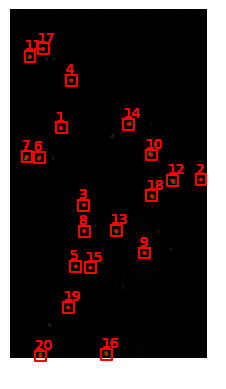

runtime:  1.6257660388946533
[[array([435, 188]), 295, array([434, 187])], [array([623, 701]), 222, array([625, 701])], [array([717, 271]), 366, array([718, 271])], [array([261, 225]), 403, array([260, 224])], [array([943, 242]), 314, array([944, 241])], [array([547, 106]), 2026, array([543, 108])], [array([547,  58]), 2376, array([540,  62])], [array([812, 271]), 328, array([814, 273])], [array([893, 493]), 1147, array([894, 495])], [array([529, 513]), 2314, array([534, 518])], [array([174,  71]), 211, array([173,  73])], [array([633, 599]), 2132, array([628, 596])], [array([815, 391]), 1425, array([812, 389])], [array([420, 439]), 2015, array([421, 435])], [array([948, 294]), 197, array([948, 295])], [array([1261,  352]), 377, array([1266,  354])], [array([145, 120]), 307, array([144, 121])], [array([688, 522]), 1486, array([684, 520])], [array([1094,  212]), 251, array([1094,  214])], [array([1266,  111]), 175, array([1272,  111])]]


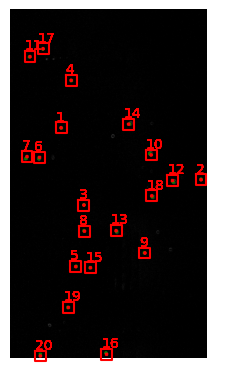

In [ ]:
def max_value_cluster(img, pixel_range, n_clusters, iterations=1):

    '''
    Creates a list of clusters searching the the maximun pixel value and performing the center of mass 
    of the pixels around it. The pixels that are part of the cluster are deleted and the process is repeated.

    Parameters
    ----------
    img : numpy array
        Image to be filtered.
    pixel_range : int
        Range of pixels to be considered around the maximun pixel value to perform the center of mass 
        (clustering).
    n_clusters : int
        Number of clusters to be found.
    iterations : int, optional
        Number of times the clustering is performed. When iterating the clusters are ordered by the cluster 
        mass and the index used a preliminary stimations . The default is 1.

    Returns
    -------
    clusters : list
        List of clusters. Each cluster is a list with the following structure:
            [ [x_pixel, y_pixel], cluster comulative mass, inital cluster position [x_max, y_max] ]    
    
    '''
    # Create a copy of the input image
    filtered_img = np.copy(img)

    clusters = []

    for i in range(n_clusters):
        # Get the maximun pixel value
        max_index = np.unravel_index(np.argmax(filtered_img), filtered_img.shape)

        cluster_x = 0
        cluster_y = 0
        cluster_mass = 0
        # Performs the clustering on the pixel range around the maximun pixel value
        for i in range(-pixel_range, pixel_range):
            for j in range(-pixel_range, pixel_range):
                if max_index[0]+i < filtered_img.shape[0] and max_index[1]+j < filtered_img.shape[1]:
                    
                    cluster_x += filtered_img[max_index[0] + i , max_index[1] + j ] * i
                    cluster_y += filtered_img[max_index[0] + i , max_index[1] + j ] * j
                    cluster_mass += filtered_img[max_index[0] + i , max_index[1] + j ] 

                    # Delete the pixels that are part of the cluster to find another maximun
                    filtered_img[max_index[0] + i , max_index[1] + j ] = 0

        if cluster_mass != 0:
            clusters.append([ np.round(max_index + [cluster_x, cluster_y]/cluster_mass).astype(int), 
                            cluster_mass, 
                            np.array(max_index)]) 

    return clusters

def max_value_cluster_2(img, pixel_range, n_clusters):
    # Create a copy of the input image
    filtered_img = np.copy(img)

    clusters = []

    for i in range(n_clusters):
        # Get the maximun pixel value
        max_index = np.unravel_index(np.argmax(filtered_img), filtered_img.shape)

        cluster_x = 0
        cluster_y = 0
        cluster_mass = 0

        # Create a mask to select the pixels within the pixel range
        mask = np.zeros_like(filtered_img, dtype=bool)
        mask[max_index[0] - pixel_range:max_index[0] + pixel_range + 1,
             max_index[1] - pixel_range:max_index[1] + pixel_range + 1] = True


        # Get the coordinates and values of the pixels within the mask
        coords = np.argwhere(mask)
        values = filtered_img[mask]

        # Perform the clustering using vectorized operations
        cluster_x = np.sum(coords[:, 0] * values)
        cluster_y = np.sum(coords[:, 1] * values)
        cluster_mass = np.sum(values)

        # Calculate the cluster centroid
        centroid = None 
        if cluster_mass != 0:
            centroid = np.round([cluster_x, cluster_y] / cluster_mass).astype(int)
        cluster_position = np.array(max_index)

        # Append the cluster to the list
        clusters.append([centroid , cluster_mass, cluster_position])

        # Set the pixels within the mask to zero
        filtered_img[mask] = 0

    return clusters

start = time.time()
filtered_frames_1 = []
for frame in frames:
    filtered_frames_1.append(max_value_cluster_2(frame, pixel_range = 20, n_clusters = 20))
end = time.time()
print('runtime: ', end - start )
print(filtered_frames_1[2])
plot_cluster(frames[2], filtered_frames_1[2], 20)

start = time.time()
filtered_frames_1 = []
for frame in frames:
    filtered_frames_1.append(max_value_cluster(frame, pixel_range = 20, n_clusters = 20, iterations=1))
end = time.time()
print('runtime: ', end - start )
print(filtered_frames_1[2])
plot_cluster(frames[2], filtered_frames_1[2], 20)



In [ ]:
import numpy as np

def max_value_cluster2(img, pixel_range, n_clusters):
    '''
    Creates a list of clusters searching for the maximum pixel value and performing the center of mass 
    of the pixels around it. The pixels that are part of the cluster are deleted, and the process is repeated.

    Parameters
    ----------
    img : numpy array
        Image to be filtered.
    pixel_range : int
        Range of pixels to be considered around the maximum pixel value to perform the center of mass 
        (clustering).
    n_clusters : int
        Max number of clusters to be found.

    Returns
    -------
    clusters : list
        List of clusters. Each cluster is a list with the following structure:
            [ [x_pixel, y_pixel], cluster cumulative mass, initial cluster position [x_max, y_max] ]    
    
    '''
    # Create a copy of the input image
    filtered_img = np.copy(img)

    clusters = []

    for i in range(n_clusters):
        # Get the maximum pixel value and its index
        max_index = np.unravel_index(np.argmax(filtered_img), filtered_img.shape)

        # Define the region of interest around the maximum pixel value
        start_row = max_index[0] - pixel_range
        end_row = max_index[0] + pixel_range + 1
        start_col = max_index[1] - pixel_range
        end_col = max_index[1] + pixel_range + 1

        # Ensure the region of interest does not go out of bounds
        if start_row < 0:
            start_row = 0
        if end_row > filtered_img.shape[0]:
            end_row = filtered_img.shape[0]
        if start_col < 0:
            start_col = 0
        if end_col > filtered_img.shape[1]:
            end_col = filtered_img.shape[1]

        # Create a mask to select the pixels within the pixel range
        mask = np.zeros_like(filtered_img, dtype=bool)
        mask[start_row:end_row, start_col:end_col] = True

        # Get the coordinates and values of the pixels within the mask
        coords = np.argwhere(mask)
        values = filtered_img[mask]

        # Perform the clustering using vectorized operations
        cluster_x = np.sum(coords[:, 0] * values)
        cluster_y = np.sum(coords[:, 1] * values)
        cluster_mass = np.sum(values)

        # Calculate the cluster centroid
        if cluster_mass != 0:
            cluster_position = np.round([cluster_x, cluster_y] / cluster_mass).astype(int)
            # Append the cluster to the list
            clusters.append([cluster_position, cluster_mass, np.array(max_index)])

        # Set the pixels within the mask to zero 
        filtered_img[mask] = 0

    return clusters

start = time.perf_counter()
for i in range(10):
    max_value_cluster2(frames[2], pixel_range = 15, n_clusters = 30)
print('runtime: ', (time.perf_counter() - start)/10 )


start = time.perf_counter()
for i in range(10):
    max_value_cluster(frames[2], pixel_range = 15, n_clusters = 30)
print('runtime: ', (time.perf_counter() - start)/10 )

runtime:  0.26751137120008933
runtime:  0.15805717959992763
